In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
cd ../gdrive/My\ Drive/Colab\ Notebooks/Graph\ Curvature\ Networks

/gdrive/My Drive/Colab Notebooks/Graph Curvature Networks


In [3]:
# colab setting
!pip install GraphRicciCurvature
!pip install grakel

import networkx as nx
import numpy as np
import math
import importlib
from IPython.display import clear_output
from IPython.core.debugger import set_trace
import pandas as pd
from collections import defaultdict


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from tqdm import tqdm_notebook

# matplotlib setting
%matplotlib inline
import matplotlib.pyplot as plt

# to print logs in jupyter notebook
import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

# load GraphRicciCuravture package
from GraphRicciCurvature.OllivierRicci import OllivierRicci
from GraphRicciCurvature.FormanRicci import FormanRicci
clear_output()

In [4]:
!pip install torch-scatter==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-sparse==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-cluster==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-spline-conv==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-geometric
clear_output()

In [28]:
def make_data(G, y):
    x = from_networkx(G)
    x.y = y 
    return x

In [5]:
# from http://www3.cs.stonybrook.edu/~chni/
def FormannCurvature(G, weighted=False, EPS=1e-15, default_node_curvature=None):
    G = G.copy()
    for (v1, v2) in G.edges():
        if not weighted:
            if G.is_directed():
                v1_nbr = set(list(G.predecessors(v1)) + list(G.successors(v1)))
                v2_nbr = set(list(G.predecessors(v2)) + list(G.successors(v2)))
            else:
                v1_nbr = set(G.neighbors(v1))
                v1_nbr.remove(v2)
                v2_nbr = set(G.neighbors(v2))
                v2_nbr.remove(v1)
            face = v1_nbr & v2_nbr
            prl_nbr = (v1_nbr | v2_nbr) - face
            G[v1][v2]["formanCurvature"] = len(face) + 2 - len(prl_nbr)
        else:
            w_e = G[v1][v2]['weight'] + np.sqrt(EPS)
            w_i = 1.
            w_j = 1.
            S_i = sum([w_i/np.sqrt(v['weight']*w_e + EPS) if k!=v2 else 0. \
                       for k,v in G[v1].items()])
            S_j = sum([w_j/np.sqrt(v['weight']*w_e + EPS) if k!=v1 else 0. \
                      for k,v in G[v2].items()])
            curv = w_e*( (w_i/w_e) + (w_j/w_e) - S_i - S_j)
            G[v1][v2]["formanCurvature"] = curv
            assert not np.isnan(curv).any()

    # Node Forman curvature
    for n in G.nodes():
        fcsum = 0  # sum of the neighbor Forman curvature
        if G.degree(n) != 0:
            for nbr in G.neighbors(n):
                if 'formanCurvature' in G[n][nbr]:
                    fcsum += G[n][nbr]['formanCurvature']
            # assign the node Forman curvature to be the average of node's adjacency edges
            G.nodes[n]['formanCurvature'] = fcsum / G.degree(n)
        else:
            G.nodes[n]['formanCurvature'] = default_node_curvature

                
    return G

# CurvConv architecture

In [6]:
import torch
from torch import nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch.utils.data import Dataset
from torch_geometric.data import Data, DataLoader
from torch_geometric.datasets import Planetoid, Amazon, Coauthor

from torch_geometric.nn import MessagePassing, GlobalAttention, GCNConv 
from torch_geometric.nn import EdgeConv, ECConv
from torch.nn import LeakyReLU,init,Linear

from torch_geometric.utils import softmax, degree, add_self_loops, remove_self_loops
from torch_geometric.utils.convert import from_networkx, to_networkx

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
_=torch.manual_seed(42)

In [7]:
################################
# DEFINE CURVATURE CONVOLUTION #
################################
class curvGN(MessagePassing):
    def __init__(self, in_channels, out_channels, bias=True):
        super(curvGN, self).__init__(aggr='add')
        self.lin = Linear(in_channels, out_channels)
        widths = [1, out_channels]
        self.w_mlp_out = create_wmlp(widths, out_channels, True)

    def forward(self, x, edge_index, w_mul):
        # edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        x = self.lin(x)
        out_weight = self.w_mlp_out(w_mul)
        out_weight = softmax(out_weight, edge_index[0])

        return self.propagate(edge_index,  x=x, out_weight=out_weight), out_weight

    def message(self, x_j, out_weight):
        return out_weight*x_j

    def update(self, aggr_out):
        # aggr_out has shape [N, out_channels]
        # Step 5: Return new node embeddings.
        return aggr_out

def create_wmlp(widths, nfeato, lbias):
    mlp_modules=[]
    for k in range(len(widths)-1):
        mlp_modules.append(Linear(widths[k], widths[k+1], bias=False))
        mlp_modules.append(LeakyReLU(0.2, True))
    mlp_modules.append(Linear(widths[len(widths)-1], nfeato, bias=lbias))

    return seq(*mlp_modules)


In [8]:
###################
# DEFINE NETWORKS #
###################
class NetСurvWithReadout(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden=64, use_dropout=True):

        super(NetСurvWithReadout, self).__init__()
        self.use_dropout = use_dropout
        self.conv1 = curvGN(num_features, hidden)
        self.conv2 = curvGN(hidden, hidden)
        self.conv3 = curvGN(hidden, hidden)
        self.conv4 = curvGN(hidden, hidden)
        self.global_attention = GlobalAttention(gate_nn=nn.Linear(hidden,1), 
                                                nn=nn.Linear(hidden,hidden))
        self.linear = nn.Linear(hidden,num_classes)

    def forward(self, data):
        x, edge_index, batch, w_mul = data.x, data.edge_index, data.batch, data.edge_attr

        x, _ = self.conv1(x, edge_index, w_mul)
        x = F.elu(x)
        x, _ = self.conv2(x, edge_index, w_mul)
        x = F.elu(x)
        if self.use_dropout:
            x = F.dropout(x, training=self.training)
        x, _ = self.conv3(x, edge_index, w_mul)
        x = F.elu(x)
        x, _ = self.conv4(x, edge_index, w_mul)
        x = F.elu(x)

        #readout
        readout = self.global_attention(x, batch) 
        x = self.linear(readout)

        return F.log_softmax(x, dim=-1)

class NetWithReadout(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden=64, use_dropout=True):
        super(NetWithReadout, self).__init__()

        self.use_dropout = use_dropout
        self.conv1 = GCNConv(num_features, hidden)
        self.conv2 = GCNConv(hidden, hidden)
        self.conv3 = GCNConv(hidden, hidden)
        self.conv4 = GCNConv(hidden, hidden)
        self.global_attention = GlobalAttention(gate_nn=nn.Linear(hidden,1), 
                                                nn=nn.Linear(hidden,hidden))
        self.linear = nn.Linear(hidden,num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        x = F.elu(x)
        if self.use_dropout:
            x = F.dropout(x, training=self.training)
        x = self.conv3(x, edge_index)
        x = F.elu(x)
        x = self.conv4(x, edge_index)
        x = F.elu(x)

        #readout
        readout = self.global_attention(x, batch) 
        x = self.linear(readout)

        return F.log_softmax(x, dim=-1)
    

## Training

In [9]:
def train_model(model, 
                dataloader,
                n_epochs=150):

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

    loss_history = []
    loss_history_epoch = []
    acc_history = []
    for epoch in tqdm_notebook(range(n_epochs)):
        for i, batch in enumerate(dataloader):

            batch = batch.to(device)
            model.train()
            optimizer.zero_grad()
            out = model(batch)

            target = torch.LongTensor(batch.y).to(device)
            loss = F.nll_loss(out, target) 
            loss.backward()
            optimizer.step()
            loss_history.append(loss.item())

        loss_history_epoch.append(np.mean(loss_history))
            # model.eval()
            # pred = out
            # _, pred = pred.max(dim=1)
            # y_pred = pred[data.test_mask].detach().cpu().numpy()
            # y_true = data.y[data.test_mask].detach().cpu().numpy()
            # # correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
            # acc = f1_metric(y_true, y_pred)
            # # acc = correct / data.test_mask.sum().item()
            # acc_history.append(acc)

    return loss_history, loss_history_epoch

# Graph classification: MUTAG

In [9]:
import grakel
from grakel import GraphKernel
from grakel.kernels import VertexHistogram, ShortestPath, WeisfeilerLehman, EdgeHistogram, CoreFramework, PropagationAttr
from grakel.datasets import fetch_dataset

mutag = fetch_dataset("MUTAG", verbose=False, as_graphs=False)
mutag_G = fetch_dataset("MUTAG", verbose=False, as_graphs=True)
X_mutag, y_mutag = mutag.data, mutag.target
y_mutag.shape

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.lfw module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


(188,)

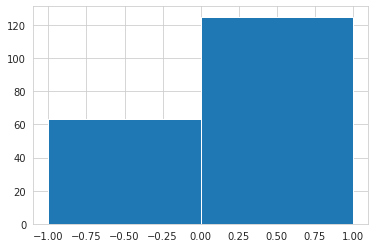

In [10]:
num_classes = len(np.unique(y_mutag))
plt.hist(y_mutag,bins=num_classes)
plt.show()
y = y_mutag.copy()
y[y == -1] = 0

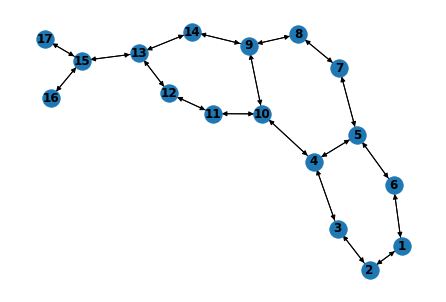

In [130]:
X_mutag_nx = []
for (edges, nodes, edges_labels) in X_mutag: 
    g = nx.DiGraph()
    
    combined_nodes_list = [(node, {'x':[float(nodes[node])]}) for node in nodes] 
    g.add_nodes_from(combined_nodes_list)

    combined_edges_list = [(edge[0], edge[1], {'edge_attr':float(edges_labels[edge])}) for edge in edges] 
    g.add_edges_from(combined_edges_list)
    
    X_mutag_nx.append(g)
nx.draw(X_mutag_nx[0], with_labels=True, font_weight='bold')

In [131]:
g_nx = X_mutag_nx[0]
g_nx.number_of_edges()

38

In [132]:
g_gk = mutag_G.data[0]
len(g_gk.get_edges())

38

In [137]:
edges_curvatures = defaultdict(list)
nodes_curvatures = defaultdict(list)

for data_nx in tqdm_notebook(X_mutag_nx):
    weighted_edges = False 

    orc = OllivierRicci(data_nx,  alpha=0.5, verbose="ERROR", nbr_topk=100)
    _ = orc.compute_ricci_curvature()
    G_orc = orc.G.copy()
    try:
        ricci_curvatures_olliver = {(v1,v2):G_orc[v1][v2]['ricciCurvature'] for v1,v2 in list(G_orc.edges)}
        ricci_curvatures_olliver_nodes = {i:G_orc.nodes[i]['ricciCurvature'] for i in list(G_orc.nodes)}
      
        G_frc = FormannCurvature(data_nx, weighted=weighted_edges)
        ricci_curvatures_formann = {(v1,v2):G_frc[v1][v2]['formanCurvature'] for v1,v2 in list(G_frc.edges)}
        ricci_curvatures_formann_nodes = {i:G_frc.nodes[i]['formanCurvature'] for i in list(G_frc.nodes)} 
    except:
        set_trace()

    edges_curvatures['Olliver'].append(ricci_curvatures_olliver)
    edges_curvatures['Formann'].append(ricci_curvatures_formann)

    nodes_curvatures['Olliver'].append(ricci_curvatures_olliver_nodes)
    nodes_curvatures['Formann'].append(ricci_curvatures_formann_nodes)

    # edges_weights =  nx.get_edge_attributes(data_nx, "weight")
clear_output()    

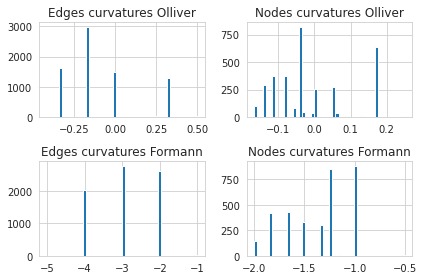

In [138]:
fig, axes = plt.subplots(ncols = 2, nrows=2)

curvature_types = ['Olliver', 'Formann']
for i,curvature_type in enumerate(curvature_types):
  all_edges_curvatures = []
  all_nodes_curvatures = []
  for (graph_curvs, nodes_curvs) in zip(edges_curvatures[curvature_type], 
                                      nodes_curvatures[curvature_type]):
      all_edges_curvatures += list(graph_curvs.values())
      all_nodes_curvatures += list(nodes_curvs.values())
  
  axes[i,0].hist(all_edges_curvatures,bins=50)
  axes[i,0].set_title(f'Edges curvatures {curvature_type}')
  axes[i,1].hist(all_nodes_curvatures,bins=50)
  axes[i,1].set_title(f'Nodes curvatures {curvature_type}')

plt.tight_layout()
plt.show()

In [188]:
# with edge curvatures
X_mutag_nx_curvature = []
for i,graph in enumerate(X_mutag_nx):
    g = graph.copy()
    for edge in g.edges:
        g[edge[0]][edge[1]]['edge_attr'] = [np.float(edges_curvatures['Olliver'][i][edge])]
    X_mutag_nx_curvature.append(g)    

# with constant edge curvatures
X_mutag_nx_CONST_curvature = []
for i,graph in enumerate(X_mutag_nx):
    g = graph.copy()
    for edge in g.edges:
        g[edge[0]][edge[1]]['edge_attr'] = [np.float(1e-15)]
    X_mutag_nx_CONST_curvature.append(g)        

# with both edge an nodes curvatures
X_mutag_nx_node_curvature = []
for i,graph in enumerate(X_mutag_nx):
    g = graph.copy()
    for edge in g.edges:
        g[edge[0]][edge[1]]['edge_attr'] = [np.float(edges_curvatures['Olliver'][i][edge])]
    for node in g.nodes:
        label = g.nodes[node]['x']
        g.nodes[node]['x'] = [np.float(nodes_curvatures['Olliver'][i][node]),
                              np.float(nodes_curvatures['Formann'][i][node]),
                              np.float(label[0])]    
    X_mutag_nx_node_curvature.append(g)      

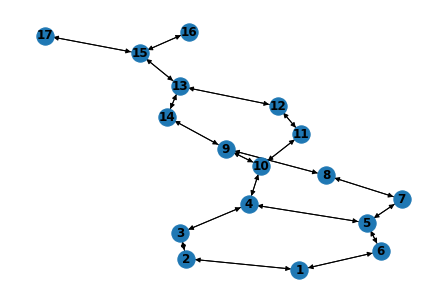

In [173]:
g_nx_c = X_mutag_nx_node_curvature[0]
nx.draw(g_nx_c, with_labels=True, font_weight='bold')

In [194]:
data_mutag = [make_data(G,y) for G,y in zip(X_mutag_nx_curvature, y)]
data_mutag_node_curv = [make_data(G,y) for G,y in zip(X_mutag_nx_node_curvature, y)]
data_mutag_CONST_curv = [make_data(G,y) for G,y in zip(X_mutag_nx_CONST_curvature, y)]

In [195]:
dataloader = DataLoader(data_mutag, batch_size=32)
dataloader_node_curv = DataLoader(data_mutag_node_curv, batch_size=32)
dataloader_CONST_curv = DataLoader(data_mutag_CONST_curv, batch_size=32)

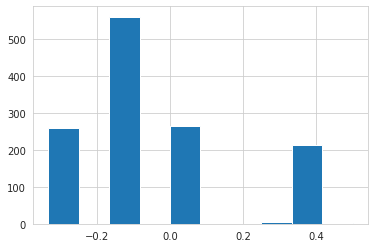

In [191]:
for batch in dataloader:
    break

plt.hist(batch.edge_attr.flatten().tolist())
plt.show()

In [181]:
net = NetWithReadout(num_features=1, num_classes=num_classes, hidden=64).to(device)
_, loss_history_baseline = train_model(net, 
                                       dataloader, 
                                       n_epochs=240)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


In [184]:
curv_net = NetСurvWithReadout(num_features=1, num_classes=num_classes ,hidden=64).to(device)
_, loss_history_curv = train_model(curv_net, 
                                  dataloader,
                                  n_epochs=240)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


In [185]:
curv_net = NetСurvWithReadout(num_features=3, num_classes=num_classes ,hidden=64).to(device)
_, loss_history_edge_node_curv = train_model(curv_net, 
                                              dataloader_node_curv,
                                              n_epochs=240)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


In [196]:
curv_net = NetСurvWithReadout(num_features=1, num_classes=num_classes ,hidden=64).to(device)
_, loss_history_CONST_curv = train_model(curv_net, 
                                          dataloader_CONST_curv,
                                          n_epochs=240)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


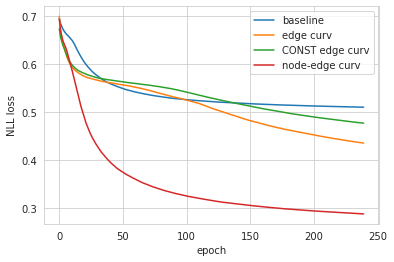

In [197]:
plt.plot(loss_history_baseline, label = 'baseline')
plt.plot(loss_history_curv, label = 'edge curv')
plt.plot(loss_history_CONST_curv, label = 'CONST edge curv')
plt.plot(loss_history_edge_node_curv, label = 'node-edge curv')
plt.xlabel('epoch')
plt.ylabel('NLL loss')
plt.legend()
plt.show()

# ABIDE-1

##### 1) One-hot encode each node?

In [10]:
ABIDE1_AAL = np.load('ABIDE1/ABIDE1_AAL.npy')
ABIDE1_CC200 = np.load('ABIDE1/ABIDE1_CC200.npy')
ABIDE1_CC400 = np.load('ABIDE1/ABIDE1_CC400.npy')
abide_traget = np.load('ABIDE1/target.npy')

In [11]:
abide_traget.shape, ABIDE1_AAL.shape, ABIDE1_CC200.shape, ABIDE1_CC400.shape

((884,), (884, 116, 116), (884, 200, 200), (884, 392, 392))

In [12]:
aj_data = ABIDE1_AAL
N = aj_data.shape[-1]
E = np.eye(N)
graphs = [nx.from_numpy_matrix(aj_data[i]-E).to_directed() for i in range(aj_data.shape[0])]

In [13]:
g_nx_abide = graphs[0]
len(g_nx_abide.edges)

13110

In [14]:
def get_curvatures(data_nx, weighted_edges = False, compute_olliver=False):
    
    results = defaultdict(dict)

    if compute_olliver:
        orc = OllivierRicci(data_nx, alpha=0.5, verbose="ERROR", nbr_topk=10)
        _ = orc.compute_ricci_curvature()
        G_orc = orc.G.copy()
        try:
            ricci_curvatures_olliver = {(v1,v2):G_orc[v1][v2]['ricciCurvature'] for v1,v2 in list(G_orc.edges)}
            ricci_curvatures_olliver_nodes = {i:G_orc.nodes[i]['ricciCurvature'] for i in list(G_orc.nodes)} 
        except:
            set_trace()
        results['Olliver']['edges'] = ricci_curvatures_olliver
        results['Olliver']['nodes'] = ricci_curvatures_olliver_nodes

    G_frc = FormannCurvature(data_nx, weighted=weighted_edges, default_node_curvature=3)
    ricci_curvatures_formann = {(v1,v2):G_frc[v1][v2]['formanCurvature'] for v1,v2 in list(G_frc.edges)}
    ricci_curvatures_formann_nodes = {i:G_frc.nodes[i]['formanCurvature'] for i in list(G_frc.nodes)}

    results['Formann']['edges'] = ricci_curvatures_formann
    results['Formann']['nodes'] = ricci_curvatures_formann_nodes

    clear_output() 

    return results

In [15]:
import multiprocessing as mp
from multiprocessing.dummy import Pool as ThreadPool

load=True

if load:
    curv_abide = np.load('curv_abide.npy', allow_pickle=True).item()
else:
    pool = ThreadPool(mp.cpu_count())
    curv_abide = pool.map(get_curvatures, graphs)
    pool.close()
    pool.join()

In [25]:
# both
X_abide_nx_both = []
for i,g in enumerate(graphs):
    for edge in g.edges:
        g[edge[0]][edge[1]]['edge_attr'] = [np.float(curv_abide[i]['Formann']['edges'][edge]), # curvature
                                            np.float(g[edge[0]][edge[1]]['weight'])] #c orrellation
    for node in g.nodes:
        onehot = np.zeros(N, dtype=np.float)
        onehot[node] = 1.
        node_curvature = np.float(curv_abide[i]['Formann']['nodes'][node])
        g.nodes[node]['x'] =  np.concatenate([onehot, [node_curvature]]).tolist()
    X_abide_nx_both.append(g)    

# corellation 
# X_abide_nx_corr = []
# for i,graph in enumerate(graphs):
#     g = graph.copy()
#     for edge in g.edges:
#         g[edge[0]][edge[1]]['edge_attr'] = [g[edge[0]][edge[1]]['weight']]
#     for node in g.nodes:
#         onehot = np.zeros(N, dtype=np.float)
#         onehot[node] = 1.
#         g.nodes[node]['x'] = onehot    
#     X_abide_nx_corr.append(g)        

In [29]:
data_abide_corr = [make_data(G,y) for G,y in zip(X_abide_nx_both, abide_traget)]
dataloader_abide_both = DataLoader(data_abide_corr, batch_size=32)

In [ ]:
for batch in dataloader:
    break

plt.hist(batch.edge_attr.flatten().tolist())
plt.show()

In [ ]:
batch.edge_attr.shape

In [ ]:
net = NetWithReadout(num_features=1, num_classes=num_classes, hidden=64).to(device)
_, loss_history_baseline_abide = train_model(net, 
                                            dataloader_abide_corr, 
                                            n_epochs=240)

In [ ]:
curv_net = NetСurvWithReadout(num_features=3, num_classes=num_classes ,hidden=64).to(device)
_, loss_history_curv_corr_abide = train_model(curv_net, 
                                              dataloader_abide_corr,
                                              n_epochs=240)

In [ ]:
curv_net = NetСurvWithReadout(num_features=3, num_classes=num_classes ,hidden=64).to(device)
_, loss_history_curv_curv_abide = train_model(curv_net, 
                                              dataloader_abide_curv,
                                              n_epochs=240)